Analisis Exploratorio de Datos (EDA)

In [8]:
# Paso 1: Agregar la ruta de funciones a sys.path
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'code')))

In [9]:
print(os.path.abspath(os.path.join('..', 'code')) in sys.path)

True


EDA: df, 'genres_dasanidado.parquet', 'pc_dasanidado.parquet'

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Mostrar todas las columnas del DataFrame
pd.set_option('display.max_columns', None)

# Leer archivos parquet.
df = pd.read_parquet(r'../data/processed_data/movies/movies_dataset_etl.parquet')
genres_desanidado = pd.read_parquet(r'../data/processed_data/movies/genres_desanidado.parquet')
pc_desanidado = pd.read_parquet(r'../data/processed_data/movies/pc_desanidado.parquet')


Comprension de los datos antes de aplicar modelo de Machine Learning

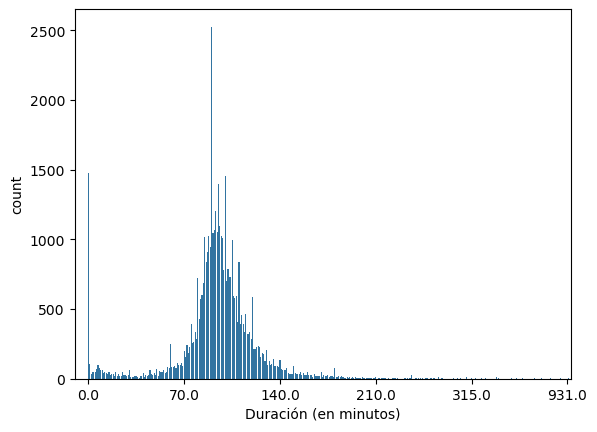

Mediana: 95.0
Media: 94.31533023089314
Moda: 90.0
desviacion std: 38.30050857440861


In [11]:
# Visualizar la distribución de la duración de las peliculas
duracion = df['runtime'].dropna()
sns.countplot(x=duracion)

# Ajustar el Eje X
plt.xlim(left=-10)
plt.xticks(ticks=plt.gca().get_xticks()[::len(plt.gca().get_xticks()) // 5])
plt.xlabel('Duración (en minutos)')
plt.show()

#Aplicar metricas de estadistica descriptiva para ver la tendencia central y dispersion de las duraciones
print('Mediana:',duracion.median())
print('Media:',duracion.mean())
print('Moda:',duracion.mode()[0])
print('desviacion std:',duracion.std())

Interpretacion de los resultados:
- La mediana de 95 minutos y la media de aproximadamente 94.3 minutos indican que la mayoría de las películas tienen una duración cercana a estos valores, 
alrededor de 1 hora y 35 minutos.
- La moda de 90 minutos sugiere que esta es una duración particularmente común en el conjunto de datos, lo que podría representar películas de "longitud estándar" o típicas.
- La desviación estándar de aproximadamente 38.3 minutos indica una variabilidad considerable en la duración de las películas. Esto es coherente con el gráfico, que muestra una gama amplia de duraciones.
- El gráfico muestra un conteo significativo de películas con duración 0. Esto podría representar datos faltantes o películas con una duración no especificada.
  La mayoría de las películas están en el rango de 60 a 140 minutos, con una alta concentración alrededor de 90 minutos. 
  Hay algunos valores extremos (con duraciones que se extienden hasta más de 300 minutos), estos casos son poco frecuentes. 

In [12]:
# manejo de los valores nulos y los ceros

# calculo la mediana y la conversion a entero (la duración de las películas generalmente se mide en minutos enteros)
mediana = int(df['runtime'].median())
# Rellenar Valores nulos
df['runtime'] = df['runtime'].fillna(mediana)
# Reemplazar valores de 0 con la mediana
df['runtime'] = df['runtime'].replace(0, mediana)

In [13]:
# Realizar un análisis exploratorio para verificar los cambios
print(df['runtime'].describe())

count    44936.000000
mean        97.443653
std         34.010863
min          1.000000
25%         87.000000
50%         95.000000
75%        107.000000
max       1256.000000
Name: runtime, dtype: float64


In [14]:
# Categorizar la duración de las películas y otros tipos de contenido 
condicion = [
    (df['runtime'] < 60), # Cortometraje
    (df['runtime'] >= 60) & (df['runtime'] <= 200), # Pelicula
    (df['runtime'] > 200) # Miniserie
]
# # Definir las elecciones de categorías
eleccion = ['Cortometraje', 'Pelicula', 'Miniserie']
# Reemplazamos los datos y convertimos tipo de dato
df['runtime'] = pd.Series(np.select(condicion, eleccion, default='Desconocido'))
df['runtime'] = df['runtime'].astype(str)

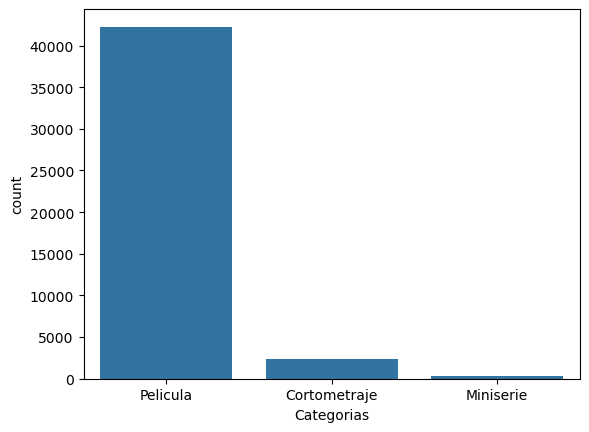

In [15]:
sns.countplot(data=df, x='runtime')
plt.xlabel('Categorias')
plt.show()

Interpretacion de los resultados:
- Predominancia de Películas: La cifra de más de 40000 películas indica que este es el formato más común en tu dataset. 

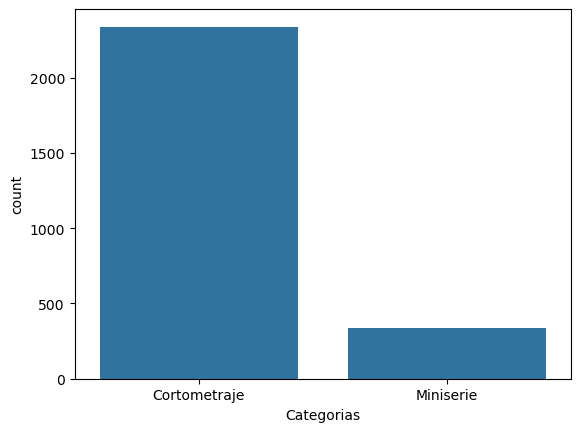

In [16]:
# Analizar únicamente los cortometrajes y miniseries
filtro = df[df['runtime'] != 'Pelicula']
sns.countplot(data=filtro, x='runtime')
plt.xlabel('Categorias')
plt.show()

Interpretacion de los resultados:
- Cortometrajes vs. Miniseries: Hay cuatro veces más cortometrajes que miniseries, esto sugiere que los cortometrajes son más populares o que se producen en mayor cantidad.

In [17]:
# Eliminar la columna de fecha completa (el año de estreno se considera relevante, el mes y el día no aportarian valor al modelo)
df.drop('release_date', axis=1, inplace=True)

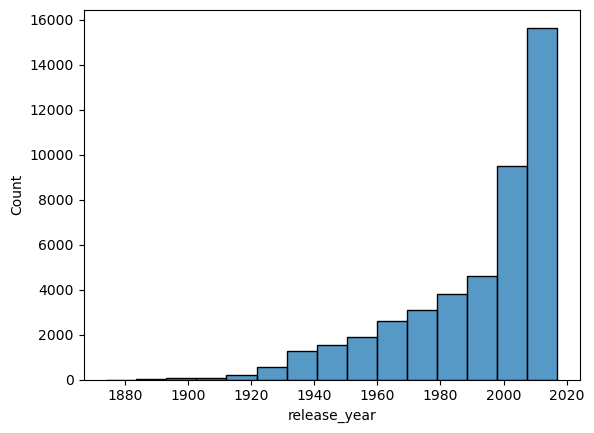

Año Pelicula mas nueva: 2017
Año Pelicula mas antigua: 1874


In [18]:
# Análizar la tendencia en la cantidad de películas a lo largo de los años
sns.histplot(df, x='release_year', bins=15)
plt.show()

print('Año Pelicula mas nueva:', df['release_year'].max())
print('Año Pelicula mas antigua:', df['release_year'].min())

Interpretacion de los resultados:
- las películas anteriores a 1900 no tienen suficiente representación en el dataset, no son representativas

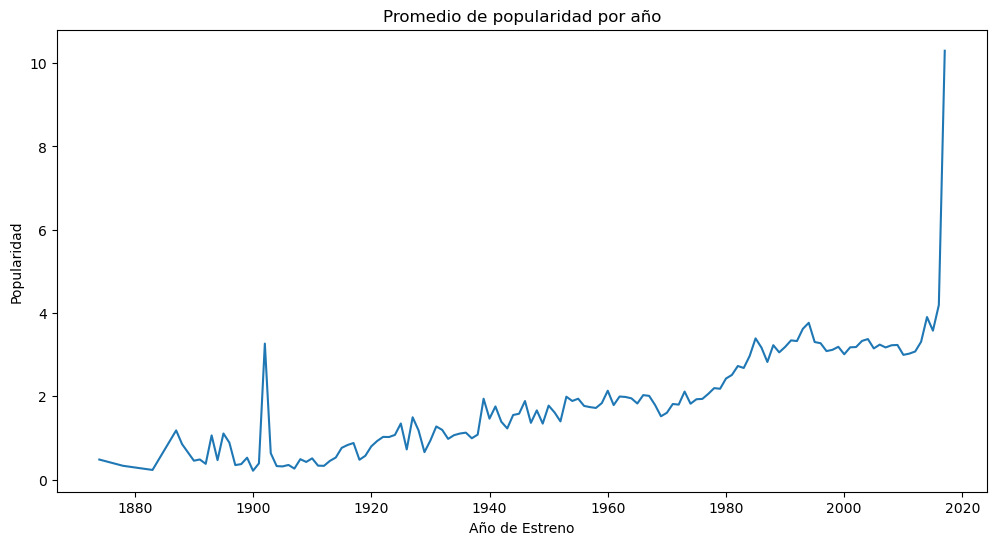

In [19]:
# Agrupar las películas por año y calcular el promedio de popularidad 
year_votes = df.groupby('release_year')['popularity'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=year_votes.index, y=year_votes.values)
plt.xlabel('Año de Estreno')
plt.ylabel('Popularidad')
plt.title('Promedio de popularidad por año')
plt.show()


In [20]:
# Eliminar películas más antiguas que 1975 
df = df[df['release_year'] > 1975]

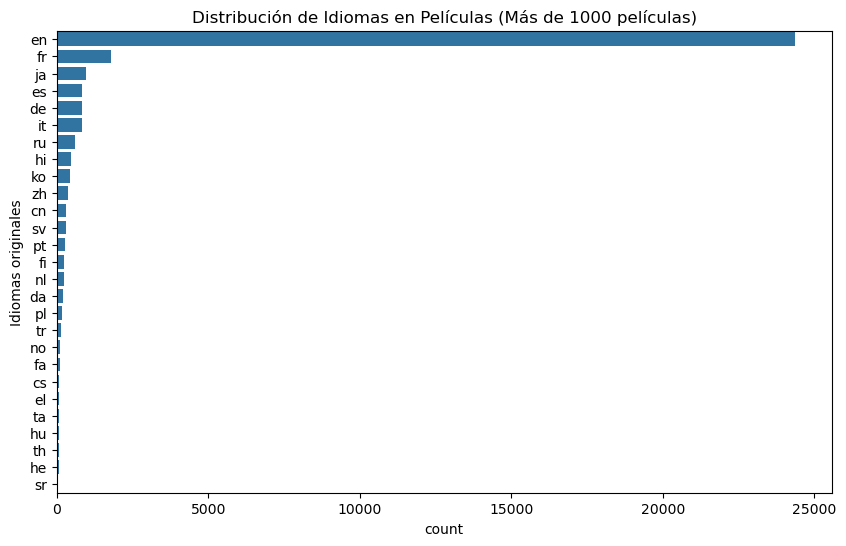

In [21]:
# Filtrar idiomas que aparecen más de 1000 veces
filtro = df.groupby('original_language').filter(lambda x: x.size > 1000)

# Obtener y ordenar idiomas por frecuencia
orden = filtro['original_language'].value_counts().index

# Visualizar la distribución de idiomas
plt.figure(figsize=(10, 6))
sns.countplot(data=filtro, y='original_language', order=orden)
plt.ylabel('Idiomas originales')
plt.title('Distribución de Idiomas en Películas (Más de 1000 películas)')
plt.show()


In [22]:
# optimizar el DataFrame con los idiomas más relevantes y eliminar columnas innecesarias
idiomas = ['es', 'en', 'fr', 'it', 'de']
df = df[df['original_language'].isin(idiomas)]

# Eliminar la columna spoken_languages_id, ya no es relevante
df = df.drop('spoken_languages_id', axis=1)

In [23]:
# Mostrar un resumen del DataFrame para verificar cambios
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 28664 entries, 0 to 44935
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   budget                   28664 non-null  float64
 1   id                       28664 non-null  int64  
 2   original_language        28664 non-null  object 
 3   overview                 28143 non-null  object 
 4   popularity               28664 non-null  float64
 5   revenue                  28664 non-null  float64
 6   runtime                  28664 non-null  object 
 7   title                    28664 non-null  object 
 8   vote_average             28664 non-null  float64
 9   vote_count               28664 non-null  int64  
 10  release_year             28664 non-null  int64  
 11  return                   28664 non-null  float64
 12  btc_id                   2903 non-null   float64
 13  btc_name                 2903 non-null   object 
 14  genres_id                28

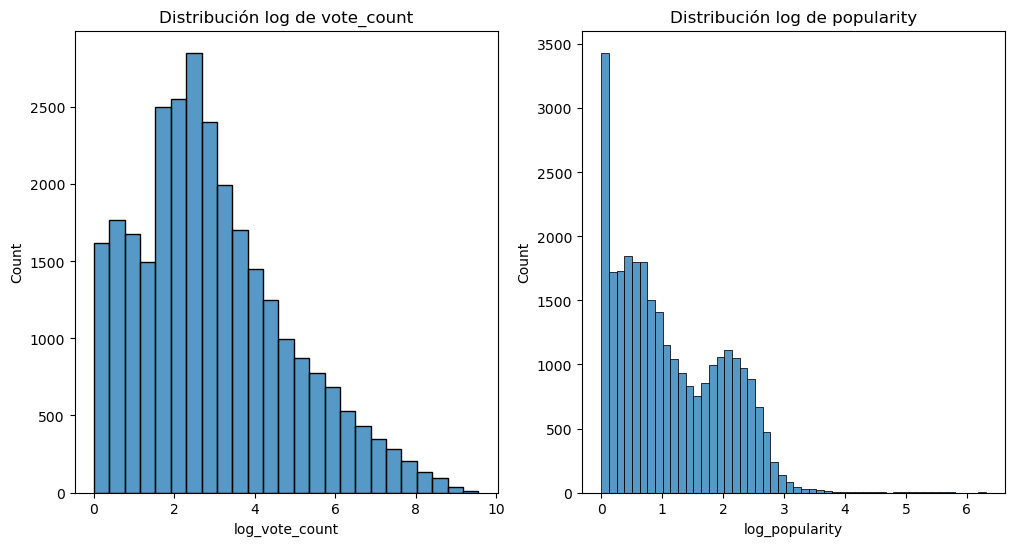

,vote_count,popularity
count,28664.000000,28664.000000
mean,158.259838,3.653284
std,605.753680,7.187713
min,0.000000,0.000000
25%,4.000000,0.480000
50%,13.000000,1.530000
75%,57.000000,5.410000
max,14075.000000,547.490000


In [24]:
# Aplicar transformaciones logarítmicas a las columnas popularity, vote_count, revenue y budget para manejar la alta asimetría en la distribución de esos datos
# Aplicar la transformación logarítmica
df['log_vote_count'] = np.log1p(df['vote_count'])
df['log_popularity'] = np.log1p(df['popularity'])
df['log_revenue'] = np.log1p(df['revenue'])
df['log_budget'] = np.log1p(df['budget'])
# Visualizar las distribuciones
fig, ax = plt.subplots(1,2,figsize=(12, 6))
# Histograma de 'vote_count'
sns.histplot(data=df, x='log_vote_count', ax=ax[0], bins=25)
ax[0].set_title('Distribución log de vote_count')

# Histograma de 'popularity'
sns.histplot(data=df, x='log_popularity', ax=ax[1], bins=50)
ax[1].set_title('Distribución log de popularity')
plt.show()
# Descripción de las columnas originales:
df[['vote_count', 'popularity']].describe()

In [25]:
# Eliminar los valores extremos en función de la popularidad 
# Calcular los cuartiles del 15% para vote_count y popularity
baja_vote = df['vote_count'].quantile(0.15)  
baja_popularity = df['popularity'].quantile(0.15)  
# Filtrar el DataFrame para eliminar los valores en el cuartil inferior
df = df[(df['vote_count'] > baja_vote) & 
                 (df['popularity'] > baja_popularity)]

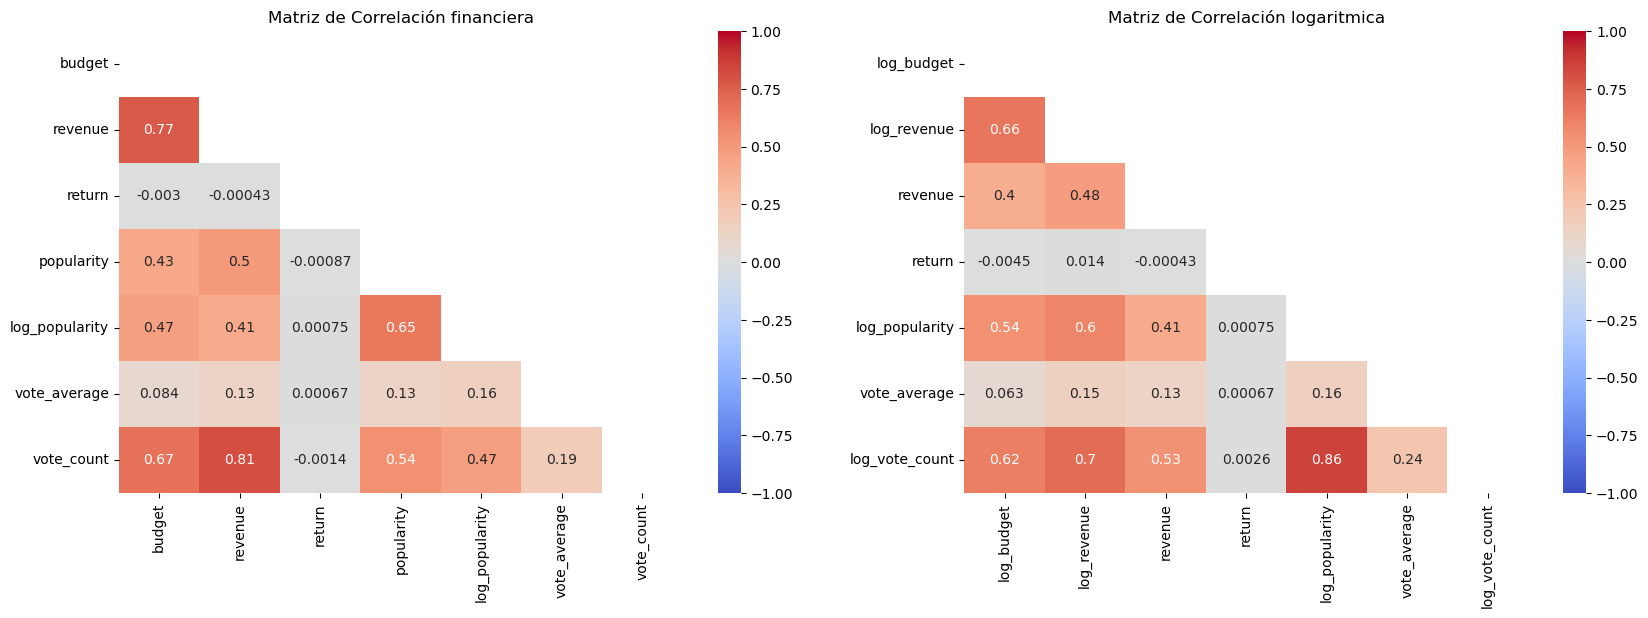

In [26]:
# Visualizar la relación entre los gastos (budget), ingresos (revenue), y la popularidad/votación de las películas 

# Seleccionar las columnas de interés
df_corr = df[['budget', 'revenue', 'return', 'popularity','log_popularity', 'vote_average', 'vote_count']]
df_corr1 = df[['log_budget', 'log_revenue','revenue', 'return', 'log_popularity', 'vote_average', 'log_vote_count']]

# Calcular la matriz de correlación
corr = df_corr.corr()
corr1 = df_corr1.corr()

# # Configur la figura
fig, ax = plt.subplots(1,2,figsize=(20, 6))

# Crear un mapa de calor para visualizar la correlación
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='coolwarm',mask=mask, vmin=-1, vmax=1,ax=ax[0])
ax[0].set_title('Matriz de Correlación financiera')
sns.heatmap(corr1, annot=True, cmap='coolwarm',mask=mask, vmin=-1, vmax=1,ax=ax[1])
ax[1].set_title('Matriz de Correlación logaritmica')
plt.show()

Interpretacion de los resultados:
- De acuerdo a los resultados obtenidos de la matriz de correlación, es claro que la relación entre los ingresos y la popularidad/votación de una película es más significativa que la de la rentabilidad después de gastos. Por tanto, es mejor mantener solo la columna revenue y eliminar las demás columnas como return, budget, y las versiones logaritmicas.

In [27]:
# Simplificar los datos eliminando las columnas innecesarias
df = df.drop('return', axis=1)
df = df.drop('budget', axis=1)

df = df.drop('log_revenue', axis=1)
df = df.drop('log_budget', axis=1)
df = df.drop('log_popularity', axis=1)
df = df.drop('log_vote_count', axis=1)
df = df.drop('production_countries_id', axis=1)

In [28]:
# Verificar que el DataFrame se ha actualizado correctamente
print(df.head())
print(df.columns)

      id original_language                                           overview  \
0    862                en  Led by Woody, Andy's toys live happily in his ...   
1   8844                en  When siblings Judy and Peter discover an encha...   
2  15602                en  A family wedding reignites the ancient feud be...   
3  31357                en  Cheated on, mistreated and stepped on, the wom...   
4  11862                en  Just when George Banks has recovered from his ...   

   popularity      revenue   runtime                        title  \
0       21.95  373554033.0  Pelicula                    toy story   
1       17.02  262797249.0  Pelicula                      jumanji   
2       11.71          0.0  Pelicula             grumpier old men   
3        3.86   81452156.0  Pelicula            waiting to exhale   
4        8.39   76578911.0  Pelicula  father of the bride part ii   

   vote_average  vote_count  release_year    btc_id  \
0           7.7        5415          1995  

In [29]:
# Eliminar btc_id (no aporta información relevante)
df = df.drop('btc_id', axis=1)

In [30]:
# visualizar los títulos de peliculas repetidos, permitir duplicados si los títulos, aunque sean los mismos, pertenecen a películas diferentes
filtro = df['title'].value_counts()
filtro

title
a christmas carol                   6
beauty and the beast                5
stranded                            5
hamlet                              5
cinderella                          4
                                   ..
the flock                           1
close my eyes                       1
the hamiltons                       1
the go-getter                       1
pooh's heffalump halloween movie    1
Name: count, Length: 21554, dtype: int64

In [31]:
# Eliminar las filas con valores nulos en la columna overview
df = df.dropna(subset=['overview'])
# Contar y luego eliminar las descripciones vacías
vacios_count_o = df[df['overview'].str.strip() == ""].shape[0] # Contiene 2 resumenes vacios.
vacios_count_t = df[df['title'].str.strip() == ""].shape[0] # Contiene 0 titulos vacios.

df = df[df['overview'].str.strip() != ""]

Preprocesamiento de texto

In [42]:
import nltk

# Configura la ruta de NLTK para tu entorno de trabajo
nltk.data.path.append('/home/carla/Documentos/DataScienceProyecto1/DataScienceProyecto1/nltk_data')

# Descargar los recursos necesarios en la carpeta especificada
nltk.download('punkt_tab', download_dir='/home/carla/Documentos/DataScienceProyecto1/DataScienceProyecto1/nltk_data')
nltk.download('stopwords', download_dir='/home/carla/Documentos/DataScienceProyecto1/DataScienceProyecto1/nltk_data')
nltk.download('wordnet', download_dir='/home/carla/Documentos/DataScienceProyecto1/DataScienceProyecto1/nltk_data')
nltk.download('averaged_perceptron_tagger_eng', download_dir='/home/carla/Documentos/DataScienceProyecto1/DataScienceProyecto1/nltk_data')


[nltk_data] Downloading package punkt_tab to /home/carla/Documentos/Da
[nltk_data]     taScienceProyecto1/DataScienceProyecto1/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /home/carla/Documentos/Da
[nltk_data]     taScienceProyecto1/DataScienceProyecto1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/carla/Documentos/Data
[nltk_data]     ScienceProyecto1/DataScienceProyecto1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to /hom
[nltk_data]     e/carla/Documentos/DataScienceProyecto1/DataSciencePro
[nltk_data]     yecto1/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [43]:
from Tokenizar import preprocess_text

# Aplicar la función de preprocesamiento, tokenizacion, lemmatizacion y eliminacion de nombres propios
df['overview'] = df['overview'].apply(preprocess_text)

In [44]:
# Eliminar la columna id
pc_desanidado = pc_desanidado.drop('id', axis=1)
# Llenar valores nulos en la columna name
pc_desanidado.name = pc_desanidado['name'].fillna('')

In [46]:

from Normalizar import normalizar_texto

# Aplicar la normalización a la columna 'name'
pc_desanidado['name'] = pc_desanidado['name'].apply(normalizar_texto)

In [47]:
# Filtrar los IDs de pc_desanidado para asegurarse que los IDs de las compañías productoras esten en el df origninal. 
pc_desanidado = pc_desanidado[pc_desanidado['production_companies_id'].isin(df['production_companies_id'])]

# Agrupar los nombres de las compañías productoras por su ID, combinándolos en una sola fila para cada ID
company_names = pc_desanidado.groupby('production_companies_id')['name'].apply(lambda x: ' '.join(x)).reset_index()

# Renombrar las columnas
company_names.columns = ['production_companies_id', 'combined_companies']
# Verificar las dimensiones del DataFrame
company_names.shape

(22257, 2)

In [48]:
# Realizar una operación de combinación y limpieza en el DataFrame df

# Unir df con company_names
df = df.merge(company_names, on='production_companies_id', how='left')
# Eliminar la columna production_companies_id de df
df = df.drop('production_companies_id', axis=1)

In [49]:
# Importar la función add_weight
from añadirPeso import add_weight
# Aplicar la función add_weight a cada fila del DataFrame
df['predictor'] = df.apply(lambda row: add_weight(row, 'combined_companies', weight=1), axis=1)

In [50]:
# Agregar información sobre los géneros cinematográficos al campo de predictores
genres_desanidado = genres_desanidado.drop('id', axis=1)
genres_desanidado.name = genres_desanidado['name'].fillna('')

In [52]:
from Normalizar import normalizar_texto

# Aplicar la normalización a la columna 'name'
genres_desanidado['name'] = genres_desanidado['name'].apply(normalizar_texto)

In [53]:
# Filtrar el DataFrame genres_desanidado
genres_desanidado = genres_desanidado[genres_desanidado['genres_id'].isin(df['genres_id'])]
# Agrupar y combinar nombres de géneros:
generos = genres_desanidado.groupby('genres_id')['name'].apply(lambda x: ' '.join(x)).reset_index()
generos.columns = ['genres_id', 'generos']
generos.shape

(22257, 2)

In [54]:
# realiza un merge del DataFrame original df con el DataFrame generos
df = df.merge(generos, on='genres_id', how='left')
df = df.drop('genres_id', axis=1)

In [55]:
# agregar el contenido de la columna generos a la columna predictor
from añadirPeso import add_weight
df['predictor'] = df.apply(lambda row: add_weight(row, 'generos', weight=2), axis=1)

In [56]:
# realizaR la concatenación del contenido de la columna btc_name al final de la columna predictor utilizando la función add_weight
from añadirPeso import add_weight
df['predictor'] = df.apply(lambda row: add_weight(row, 'btc_name', weight=1), axis=1)

In [57]:
cast_df = pd.read_parquet(r'../data/processed_data/credits/cast_desanidado.parquet')
cast_df = cast_df.drop('id', axis=1)
cast_df = cast_df.drop('gender', axis=1)
cast_df = cast_df.drop('cast_id', axis=1)

In [58]:
cast_df.name = cast_df['name'].fillna('')

In [59]:
from Normalizar import normalizar_texto

# Aplicar la normalización a la columna 'name'
cast_df['name'] = cast_df['name'].apply(normalizar_texto)

In [60]:
# filtrar y agrupar los nombres de los actores en el DataFrame cast_df en función de una columna común (id_df) 
cast_df = cast_df[cast_df['id_df'].isin(df['id'])]
actores = cast_df.groupby('id_df')['name'].apply(lambda x: ' '.join(x)).reset_index()
actores.columns = ['id', 'actores']
actores.shape

(21761, 2)

In [61]:
# Fusionar el DataFrame df con el DataFrame actores en función de la columna id
df = df.merge(actores, on='id', how='left')

In [62]:
# añadir información sobre los actores al DataFrame df en una nueva columna llamada predictor
from añadirPeso import add_weight
df['predictor'] = df.apply(lambda row: add_weight(row, 'actores', weight=1), axis=1)

In [63]:
# reestructurar el DataFrame df para conservar solo las columnas 'title' y 'predictor'
df = df[['title','predictor']]

In [ ]:
# preparar el DataFrame df para que el índice sea limpio y sin valores previos
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22257 entries, 0 to 22256
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      22257 non-null  object
 1   predictor  22257 non-null  object
dtypes: object(2)
memory usage: 347.9+ KB


In [65]:
import sys
import os

# crear un directorio de salida
output_dir = '../data/processed_data/'
os.makedirs(output_dir, exist_ok=True)

In [66]:
# guardar un DataFrame de pandas en un archivo Parquet
parquet_path = os.path.join(output_dir, 'modelo_dataset.parquet')
df.to_parquet(parquet_path, engine='pyarrow', compression='snappy', index=False)

print("Datos exportados correctamente a 'data/processed_data/'")

Datos exportados correctamente a 'data/processed_data/'
